# The Theta Method

## Kevin Sheppard

### Advanced Financial Econometrics: Forecasting

### Background

Material available on [my site](https://www.kevinsheppard.com/teaching/mfe/advanced-financial-econometrics-forecasting/).

More detail in [pre-recorded lectures](https://www.youtube.com/playlist?list=PLVR_rJLcetzmES8tqjgqlQw1Vx2IKMVot).

### Viewing as a Presentation

This notebook has been written with RISE in mind. To view it as a presentation, install RISE using pip install RISE and then press ALT + R to enter slides model.


### Updating statsmodels

Some of the code in this notebook requires a recent version statsmodels (as of May 2020). If you already have statsmodels 0.12.0 or later, you can ignore this step.

You can install the development version of statsmodels using the command

```
pip install statsmodels --upgrade --pre --find-links https://7933911d6844c6c53a7d-47bd50c35cd79bd838daf386af554a83.ssl.cf2.rackcdn.com/ 
```

This is a repository where pre-release versions are stored.

# Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.api import SARIMAX, add_trend
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from scipy import stats
import seaborn as sns
sns.set_style("darkgrid")
# These values are optimized for full-screen on a high-resolution monitor
plt.rc("figure", figsize=(32,12))
plt.rc("font", size=28)
plt.rc("lines", linewidth=4)

# Load some data

We will use the 432-observation M4 data to explore ES.

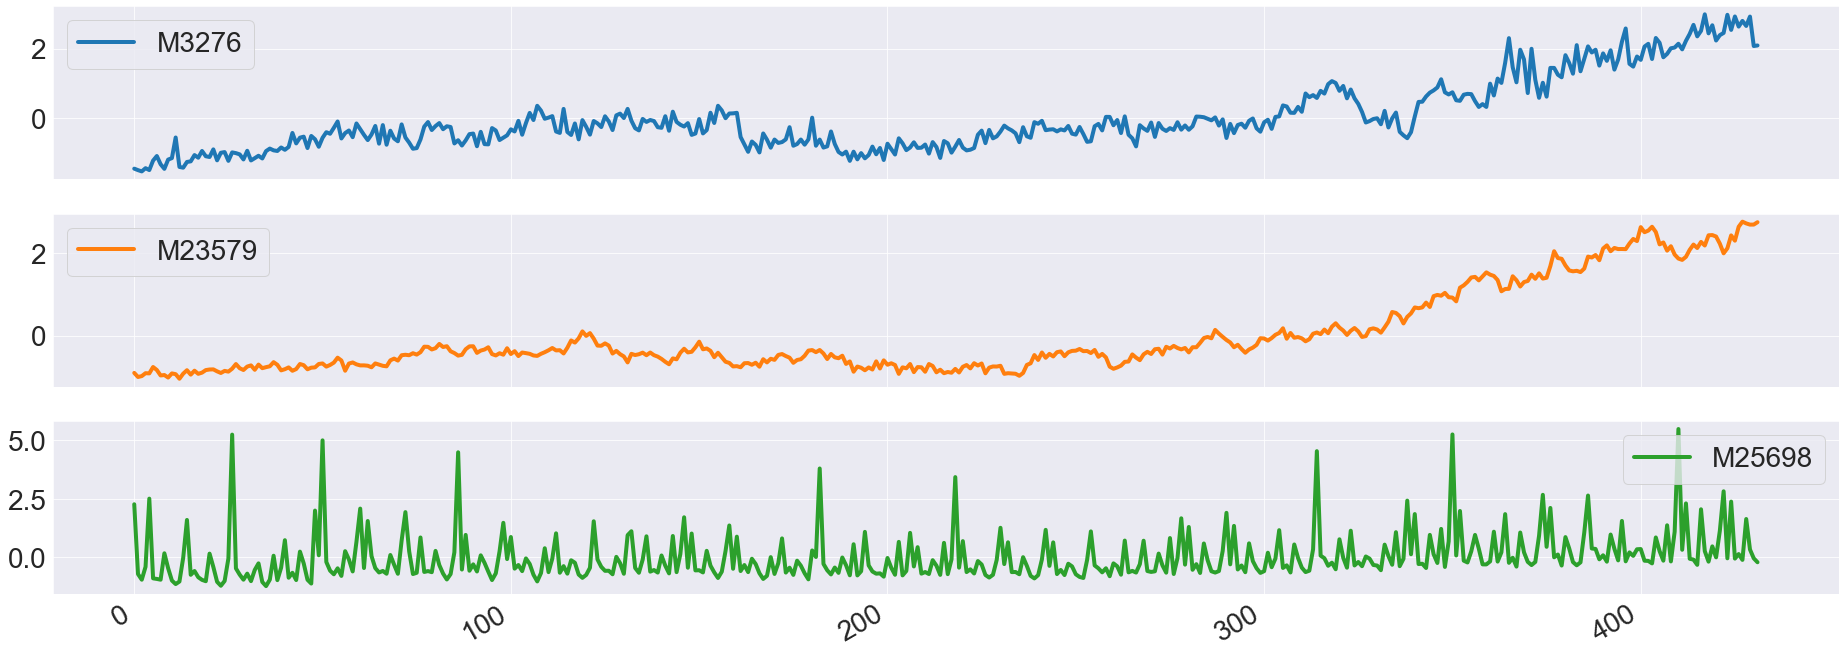

In [2]:
df: pd.DataFrame = pd.read_hdf("./monthly-data.h5", f"nobs_432")
data = df[["M3276","M23579","M25698"]]
data.index = np.arange(data.shape[0])
std_data = (data - data.mean()) / data.std()
_ = std_data.plot(subplots=True)

# Theta Line Estimation

The parameters of the $\theta$-line, $a_0$ and $b_0$ are estimated using OLS.  These are then used to construct the $\theta$-line.

$$ Y_{t,\theta}=a_{\theta}+b_{\theta}\left(t-1\right)+\theta X_{t} $$

$$
\begin{align*}
\hat{a}_0,\hat{b}_0 = \arg\!\min_{a_0,b_0} \sum_{t=1}^{T}\left(X_{t}-Y_{t,\theta}\right)^{2} & =\sum_{t=1}^{T}\left(X_{t}-a_{\theta}-b_{\theta}\left(t-1\right)-\theta X_{t}\right)^{2}\\
 & =\sum_{t=1}^{T}\left(\left(1-\theta\right)X_{t}-a_{\theta}-b_{\theta}\left(t-1\right)\right)^{2}
\end{align*}
$$

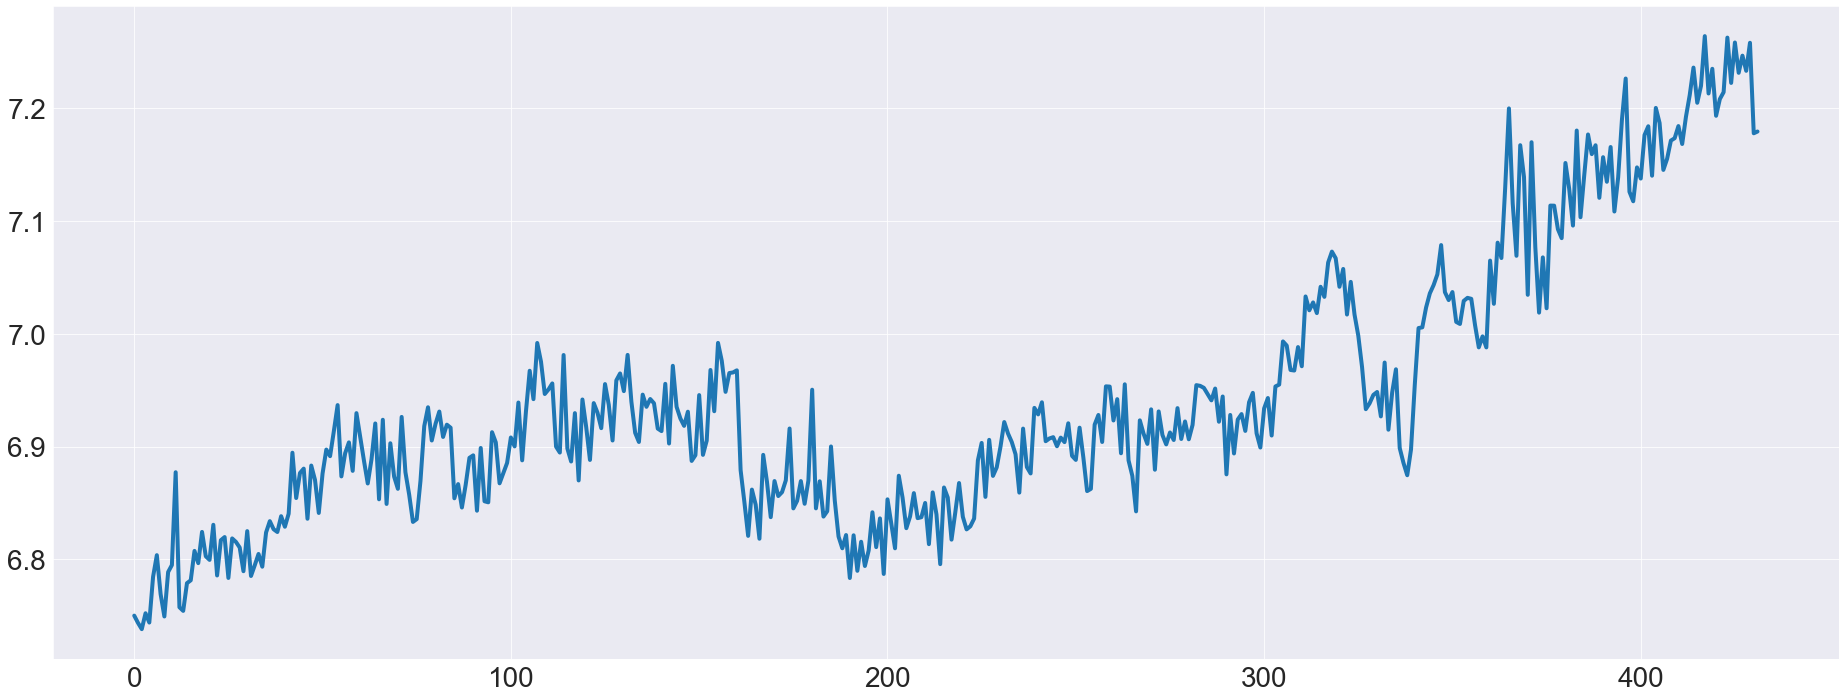

In [3]:
x = np.log(data["M3276"])
_ = x.plot()

In [4]:
from statsmodels.tsa.tsatools import add_trend
joined = add_trend(x, "ct", prepend=False)
joined.trend -= 1
rhs = joined.iloc[:, -2:]
rhs.columns = ["a0", "b0"]
theta_lines = pd.DataFrame(None, index=joined.index, dtype=np.double)
params = pd.DataFrame(None, index=["a0","b0"], dtype=np.double)
for theta in (-2, -1, 0, 0.5, 0.75, 1.25, 1.5, 2):
    lhs = x * (1-theta)
    res = OLS(lhs, rhs).fit()
    # Add back in x * theta for get the line
    theta_lines[f"θ = {theta}"] = res.fittedvalues + x * theta
    params[theta] = res.params
theta_lines["x (θ = 1)"] = x


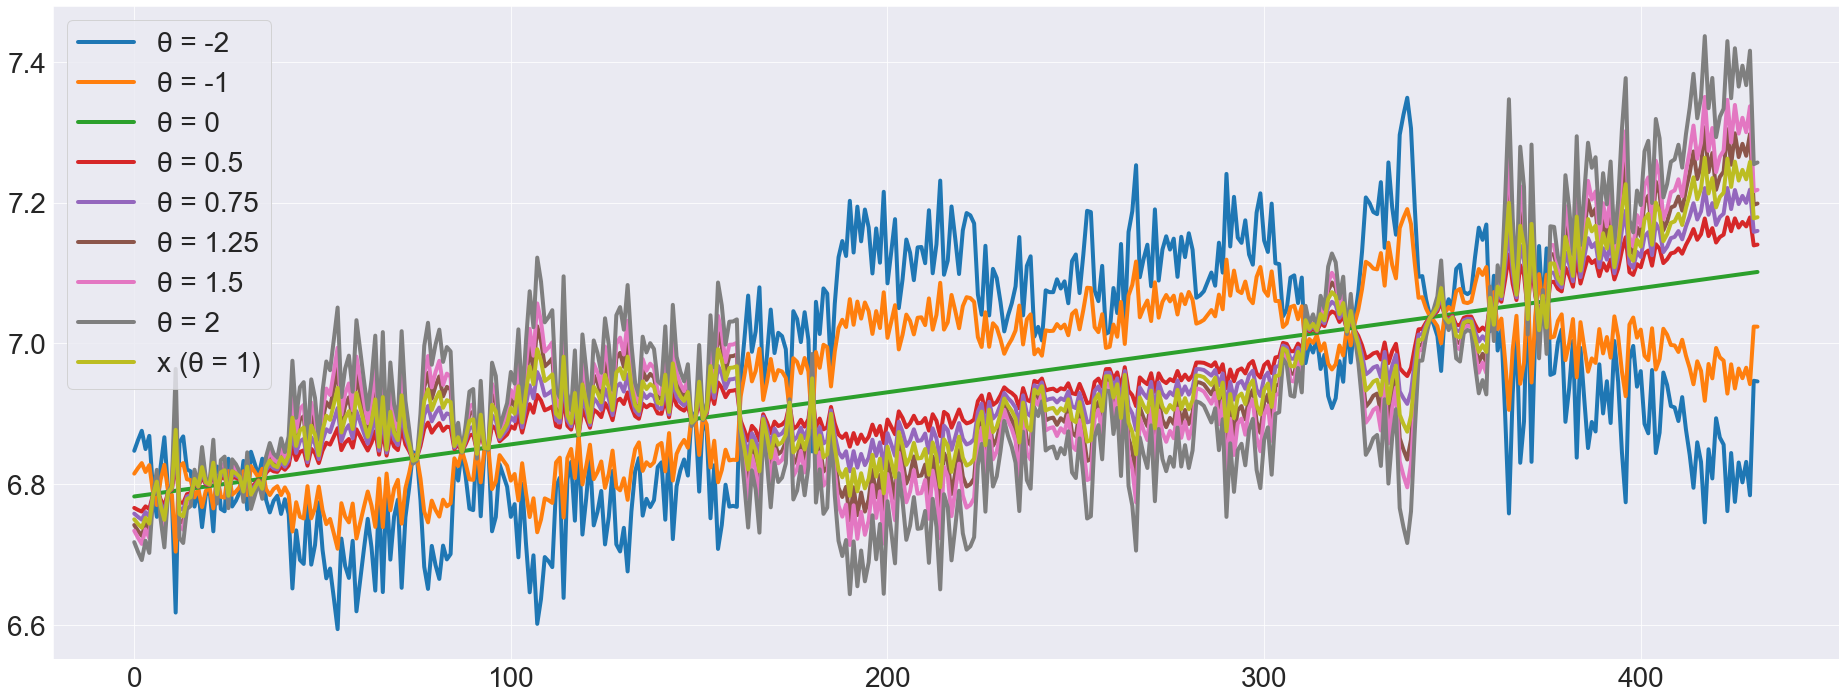

In [5]:
_ = theta_lines.plot()

In [6]:
# These are the parameters of the 0-line
params[0]

a0    6.782643
b0    0.000740
Name: 0.0, dtype: float64

# Forecasting

The forecast depends on a SES of $X_t$ plus a trend.

$$
\begin{align*}
\hat{X}_{T+h|T} & =\tilde{X}_{T+h|T}+\frac{1}{2}\hat{b}_{0}\left(h-1+\frac{1}{\alpha}-\frac{\left(1-\alpha\right)^{T}}{\alpha}\right)\\
\tilde{X}_{T+h|T} & =\alpha\sum_{i=0}^{T-1}\left(1-\alpha\right)^{i}X_{T-i}+\left(1-\alpha\right)X_{1}
\end{align*}
$$

In [7]:
rhs_oos = np.ones((24, 2))
rhs_oos[:, 1] = np.arange(24) + rhs["b0"].max() + 1
ses = ExponentialSmoothing(x).fit()
alpha = ses.params.smoothing_level
b0 = params[0]["b0"]
t = x.shape[0]
ses_forecast = ses.forecast(24) 
trend = 1/2 * b0 * (np.arange(1, 25) - 1 + 1/alpha - (1-alpha) ** t / alpha)
idx_max = x.index.max()
forecast = pd.DataFrame(index=np.arange(idx_max + 24 + 1), columns=["Theta", "x"])
forecast["Theta"] = list(x) + list(ses_forecast + trend)
forecast["x"] = x

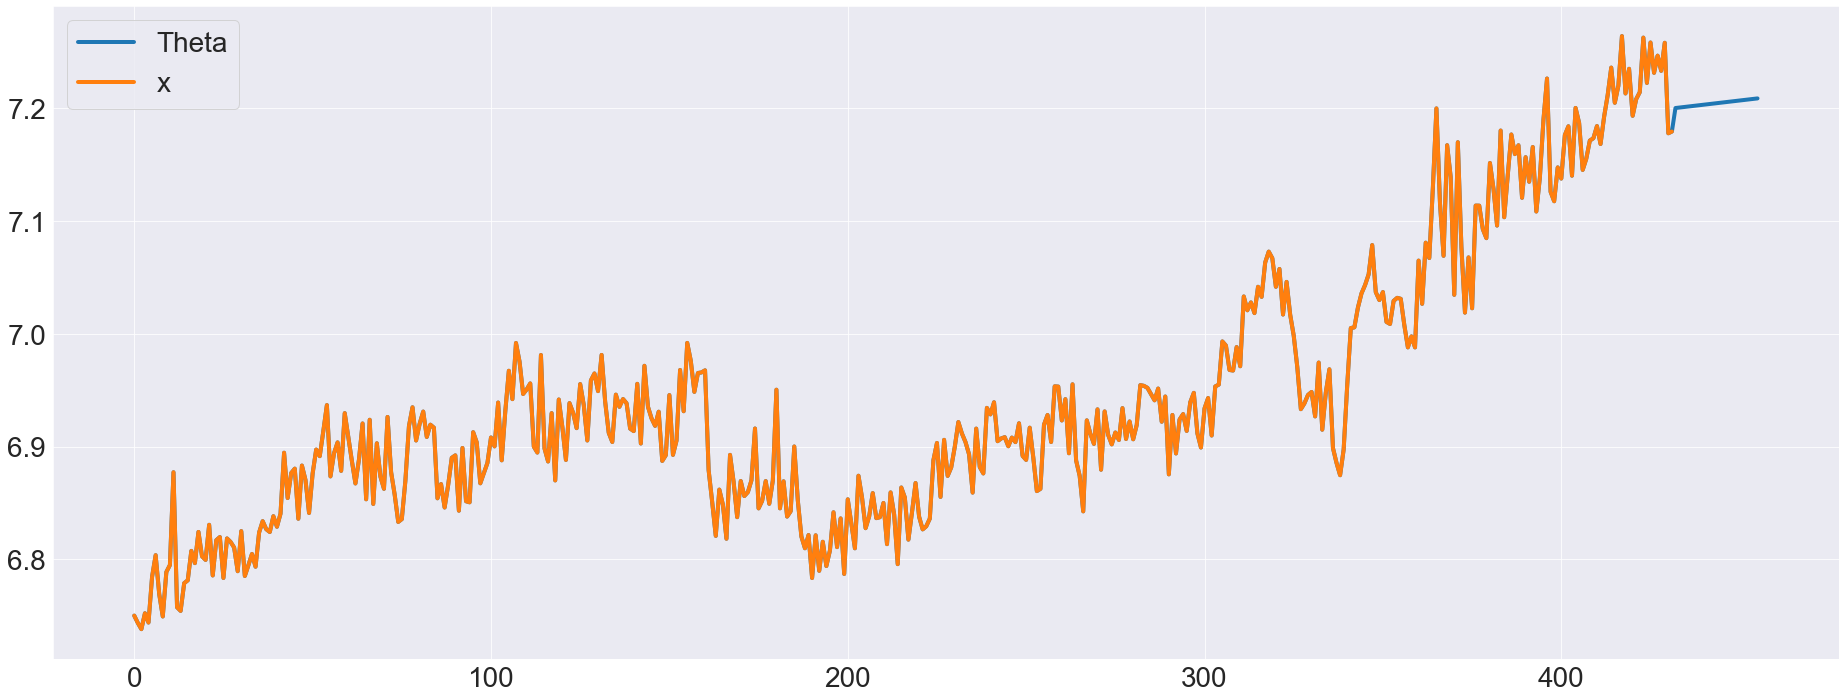

In [8]:
_ = forecast.plot()

# MLE

The parameters can also be estimated using MLE.  In the notation of a SARIMA, the order is $(P, D, Q) = (0, 1, 1)$.

$$ \Delta X_{t}=b+\left(\alpha-1\right)\epsilon_{t-1}+\epsilon_{t} $$

The forecasts can also be directly computed using the model.

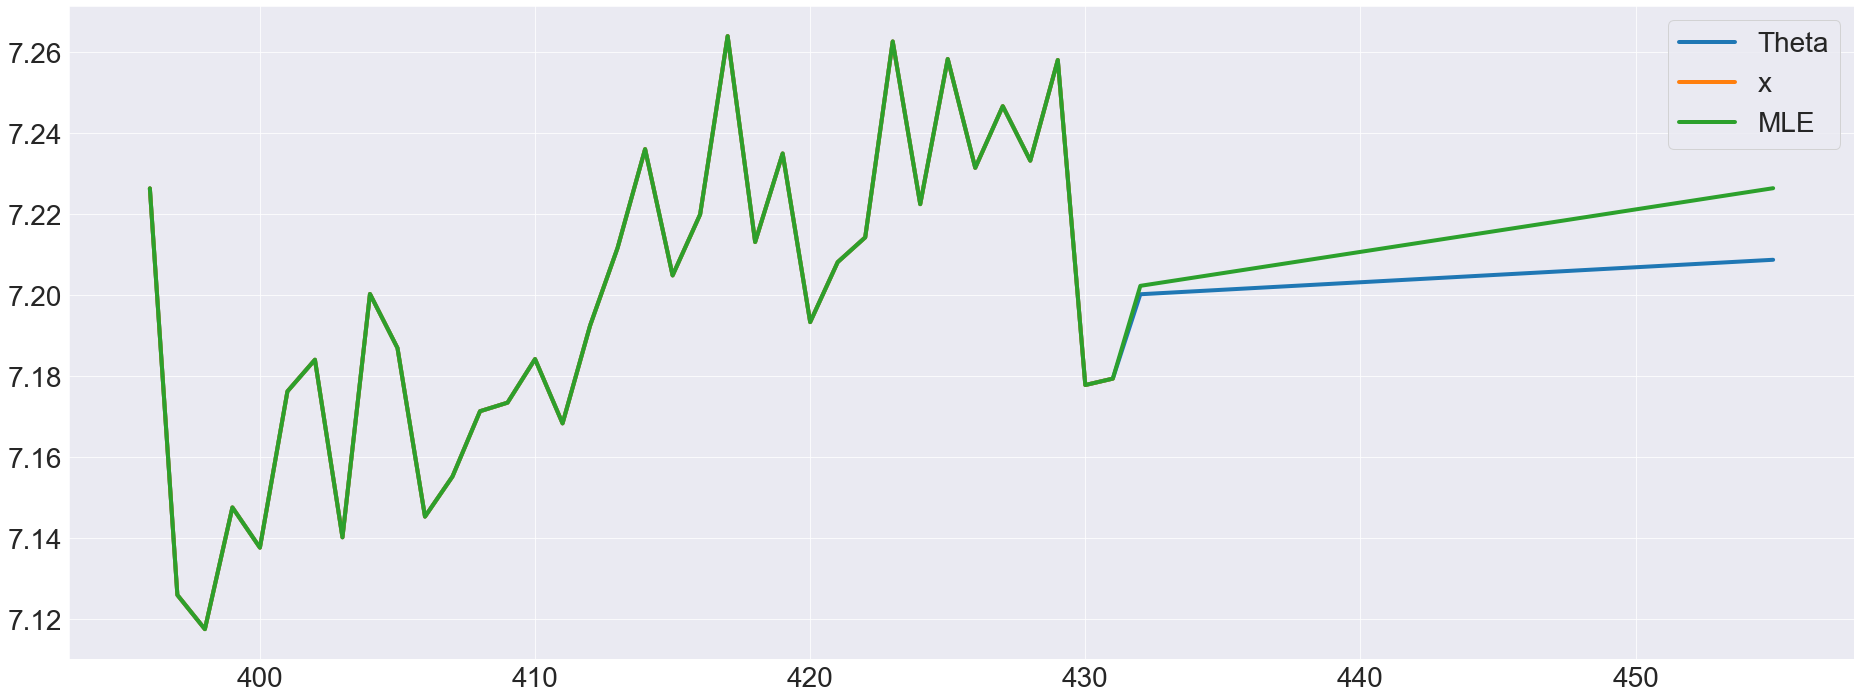

In [9]:
mod = SARIMAX(x, order=(0, 1, 1), trend="c")
res = mod.fit()
res.params
alpha_mle = res.params["ma.L1"] + 1
b0_mle = 2 * res.params.intercept
idx = ["b0", "alpha"]
pd.DataFrame({"theta":pd.Series([b0,alpha],index=idx),
              "mle":pd.Series([b0_mle,alpha_mle],index=idx)})
forecast["MLE"] = forecast.x
mle_forecasts = res.forecast(24)
forecast.loc[mle_forecasts.index, "MLE"] = mle_forecasts
_ = forecast.tail(60).plot()

# Indirect Forecasting

We can also use the parameters computed by MLE with the original forecasting method. Here we fix the two parameters.

The forecasts are identical.

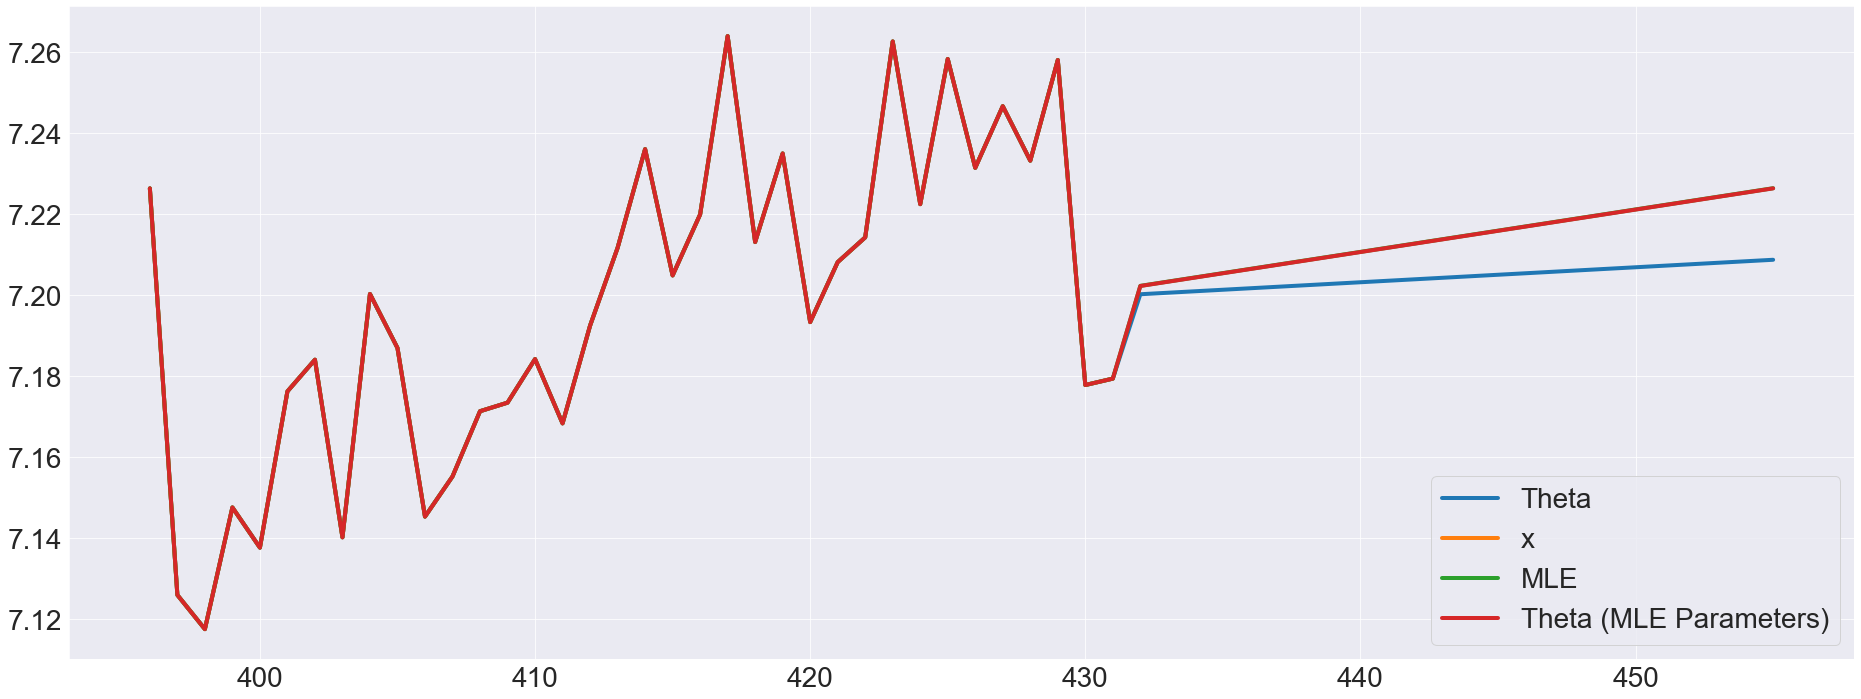

In [10]:
ses_mle = ExponentialSmoothing(x, initial_level=x[0], initialization_method="known")
with ses_mle.fix_params({'smoothing_level': alpha_mle}):
    res = ses_mle.fit()
forecast["Theta (MLE Parameters)"] = forecast.x
ses_mle_forecasts = res.forecast(24)
trend_mle = 1/2 * b0_mle * (np.arange(1, 25) - 1 + 1/alpha - (1-alpha) ** t / alpha)
forecast.loc[mle_forecasts.index, "Theta (MLE Parameters)"] = ses_mle_forecasts + trend_mle
_ = forecast.tail(60).plot()